# Anchor-Probe/Probe-Probe/Anchor-Anchor Hidden Distance
**Goal**: Analyze the distance between the hidden representation of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Anchors and Probes Data

In [2]:
all_anchors_data = []
all_probes_data = []

for dilution in range(1, 4):
    # Load anchors data
    anchors_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-hidden.pkl')
    anchors_data = anchors_data[anchors_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])].reset_index(drop=True)
    anchors_data['dilution'] = dilution

    # Load probes data
    probes_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-hidden.pkl')
    probes_data['dilution'] = dilution

    all_anchors_data.append(anchors_data)
    all_probes_data.append(probes_data)

all_anchors_data = pd.concat(all_anchors_data)
all_probes_data = pd.concat(all_probes_data)

# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [3]:
all_anchors_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution
0,1850,"[0.02357764, 0.09254456, 0.4413847, 0.4782121,...",0,slit,slit,ANC_REG,1
1,1850,"[0.9571533, 0.2817168, 0.03160163, 0.991742, 0...",1,thax,Tks,ANC_REG,1
2,1850,"[0.3521752, 0.7513624, 0.001733726, 0.9937267,...",2,kleef,klEf,ANC_REG,1
3,1850,"[0.01986267, 0.9182791, 0.1537067, 0.3663398, ...",3,krim,krim,ANC_REG,1
4,1850,"[0.9145361, 0.9304242, 0.7172889, 0.07215772, ...",4,nisp,nisp,ANC_REG,1


In [4]:
anchor_probe_mapping.head()

,anchor,probes,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


## Calculation of Distance between Anchors and Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [5]:
results = []
for dilution in [1, 2, 3]:
    anchors_data = all_anchors_data[all_anchors_data['dilution'] == dilution]
    probes_data = all_probes_data[all_probes_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        anchor_hidden = anchors_data[anchors_data['orth'].isin(row['anchor'])]
        probes_hidden = probes_data[probes_data['orth'].isin(row['probes'])]

        max_epoch = max(anchor_hidden['epoch'].unique())
        epoch_anchor_hidden = np.array(anchor_hidden[anchor_hidden['epoch'] == max_epoch]['hidden'].tolist())
        epoch_probe_hidden = np.array(probes_hidden[probes_hidden['epoch'] == max_epoch]['hidden'].tolist())

        results.append({
            'dilution': dilution,
            'anchor': row['anchor'],
            'probes': row['probes'],
            'type': row['type'],
            'ap_cosine_distances': cosine_distances(epoch_anchor_hidden, epoch_probe_hidden),
            'ap_l1_distances': manhattan_distances(epoch_anchor_hidden, epoch_probe_hidden),
            'aa_cosine_distances': cosine_distances(epoch_anchor_hidden, epoch_anchor_hidden),
            'aa_l1_distances': manhattan_distances(epoch_anchor_hidden, epoch_anchor_hidden),
            'pp_cosine_distances': cosine_distances(epoch_probe_hidden, epoch_probe_hidden),
            'pp_l1_distances': manhattan_distances(epoch_probe_hidden, epoch_probe_hidden),
        })

Dilution 3: 100%|██████████| 27/27 [00:00<00:00, 85.43it/s]


In [6]:
results_df = pd.DataFrame(results)
results_df['mean_ap_cosine_distance'] = results_df['ap_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_ap_l1_distance'] = results_df['ap_l1_distances'].apply(lambda x: x.mean())
results_df['mean_aa_cosine_distance'] = results_df['aa_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_aa_l1_distance'] = results_df['aa_l1_distances'].apply(lambda x: x.mean())
results_df['mean_pp_cosine_distance'] = results_df['pp_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_pp_l1_distance'] = results_df['pp_l1_distances'].apply(lambda x: x.mean())
results_df['first_anchor'] = results_df['anchor'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['type', 'first_anchor']).reset_index(drop=True)

In [7]:
results_df.head()

,dilution,anchor,probes,type,ap_cosine_distances,ap_l1_distances,aa_cosine_distances,aa_l1_distances,pp_cosine_distances,pp_l1_distances,mean_ap_cosine_distance,mean_ap_l1_distance,mean_aa_cosine_distance,mean_aa_l1_distance,mean_pp_cosine_distance,mean_pp_l1_distance,first_anchor
0,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.21800335122961934, 0.2517655129697125, 0.2...","[[17.6476583691789, 19.684967321685605, 20.882...",[[0.0]],[[0.0]],"[[0.0, 0.20273377411305427, 0.2883885563793771...","[[0.0, 17.0343099752873, 21.1028184383057, 18....",0.255847,19.996887,0.000000,0.000000,0.172710,13.574625,blome
1,2,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.26391453278341637, 0.267940866611059, 0.25...","[[24.0782960494983, 23.907839548650408, 24.502...","[[0.0, 0.12731614715555284], [0.12731614715555...","[[0.0, 15.156212104455694], [15.15621210445569...","[[0.0, 0.1922274994401787, 0.22202065633017543...","[[0.0, 19.686480138561503, 23.485776818614895,...",0.231743,22.725919,0.063658,7.578106,0.144533,15.619175,blome
2,3,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.22165958585671852, 0.2102543908021035, 0.1...","[[21.92999662286621, 23.0803313408793, 20.6879...","[[0.0, 0.14537736652258382, 0.156452236066411]...","[[0.0, 18.128160483503095, 18.7488415745118], ...","[[0.0, 0.18688441177304593, 0.2439180726504182...","[[0.0, 18.310897276381297, 22.144836826738192,...",0.204271,21.237083,0.098009,11.941401,0.135708,14.070572,blome
3,1,"[clead, smead, pread]","[glead, yead, jead, kead]",AMB,"[[0.12661905476358848, 0.24132062139621369, 0....","[[11.318930225388602, 16.438691319733397, 15.6...",[[0.0]],[[0.0]],"[[0.0, 0.30836186734888205, 0.1216017894358936...","[[0.0, 19.820647539391608, 12.239395145536603,...",0.184791,14.808889,0.000000,0.000000,0.165350,12.696926,clead
4,2,"[clead, smead, pread]","[glead, yead, jead, kead]",AMB,"[[0.11655499555699589, 0.3058259644189927, 0.1...","[[13.710387456395004, 25.404667804611, 17.4553...","[[0.0, 0.23222608623902374], [0.23222608623902...","[[0.0, 21.723456453064802], [21.72345645306480...","[[0.0, 0.2986150360589992, 0.17768412950861967...","[[0.0, 27.189362989125392, 19.006900136660082,...",0.218621,20.503435,0.116113,10.861728,0.173355,16.439966,clead


## Mean Cosine and L1 Distance by Anchor/Probe Type

This first pair of graphs aggregate all three dilution levels together. The idea is that each anchor/probe set is weighted equally, and the dilution levels are weighted equally - i.e. each point of the curve is composed of 30 datapoints (3 dilution levels times 10 anchor sets) for REG/EXC and 21 datapoints for ambiguous.

The error bands are based on a confidence interval. The confidence interval being plotted is the 68% confidence interval - which approximately corresponds to standard error.

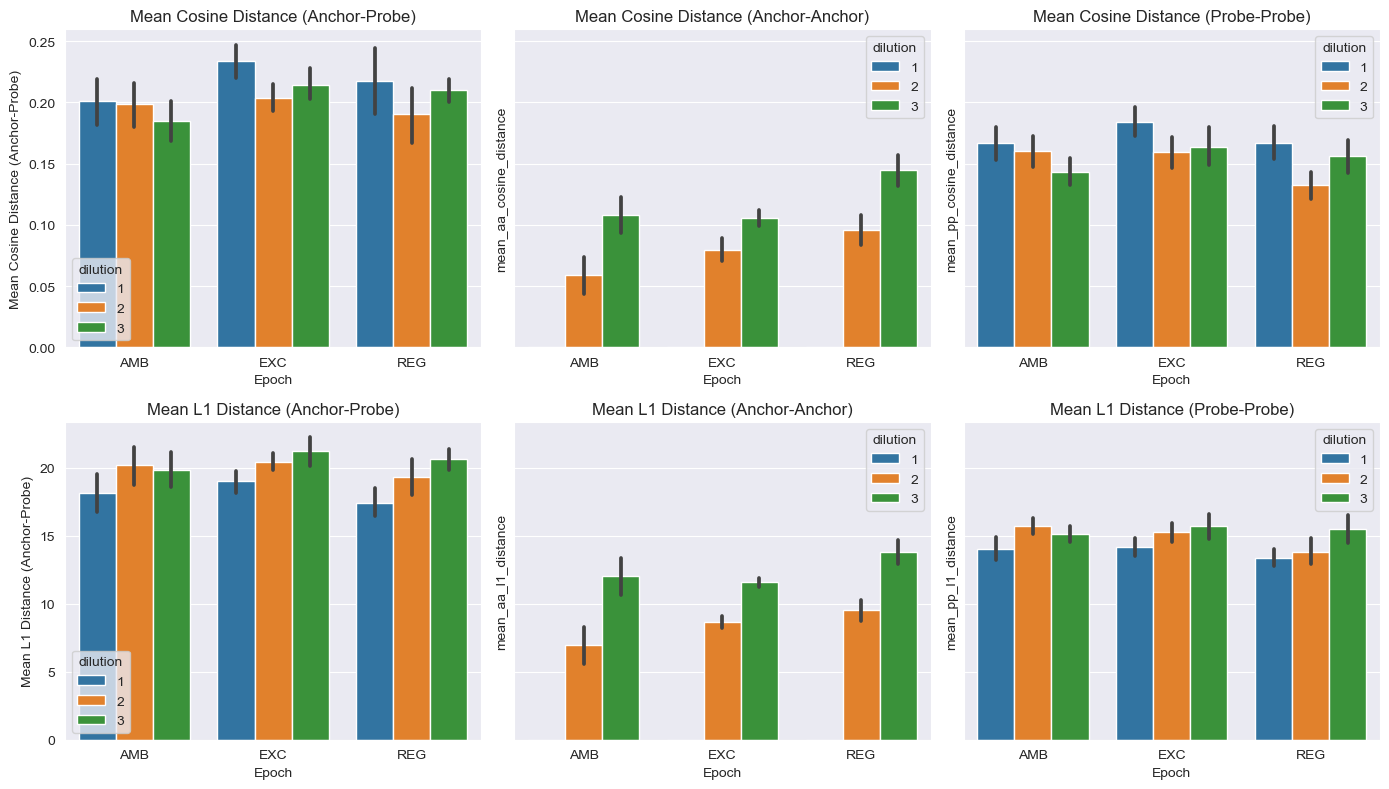

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey='row')

for distance, ax in zip(['cosine', 'l1'], axs):

    sns.barplot(data=results_df, x='type', y=f'mean_ap_{distance}_distance', hue='dilution', ax=ax[0], ci=68)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel(f'Mean {distance.title()} Distance (Anchor-Probe)')
    ax[0].set_title(f'Mean {distance.title()} Distance (Anchor-Probe)')

    sns.barplot(data=results_df, x='type', y=f'mean_aa_{distance}_distance', hue='dilution', ax=ax[1], ci=68)
    ax[1].set_xlabel('Epoch')
    ax[1].set_title(f'Mean {distance.title()} Distance (Anchor-Anchor)')

    sns.barplot(data=results_df, x='type', y=f'mean_pp_{distance}_distance', hue='dilution', ax=ax[2], ci=68)
    ax[2].set_xlabel('Epoch')
    ax[2].set_title(f'Mean {distance.title()} Distance (Probe-Probe)')


plt.tight_layout()
plt.show()